<a href="https://colab.research.google.com/github/SanjayGanapathy/HousePricePrediction/blob/main/HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Load the training data
train_data = pd.read_csv('train.csv')

# Calculate correlations
correlations = train_data.corr()
correlations_with_target = correlations['SalePrice']

# Set a threshold for correlation value
threshold = 0.1

# Identify columns with low correlation to SalePrice
irrelevant_columns = correlations_with_target[abs(correlations_with_target) < threshold].index.tolist()
print("Irrelevant Columns:", irrelevant_columns)


Irrelevant Columns: ['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']


<ipython-input-13-9d3118c6a480>:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = train_data.corr()


1. Random Forest Regression

R-squared: 0.8880193361989016
      Actual Prices  Predicted Prices
892          154500     140593.333333
1105         325000     330456.106667
413          115000     117204.666667
522          159000     160609.333333
1036         315500     320838.040000
...             ...               ...
479           89471     120796.053333
1361         260000     245601.133333
802          189000     178053.066667
651          108000     137713.440000
722          124500     117575.040000

[292 rows x 2 columns]


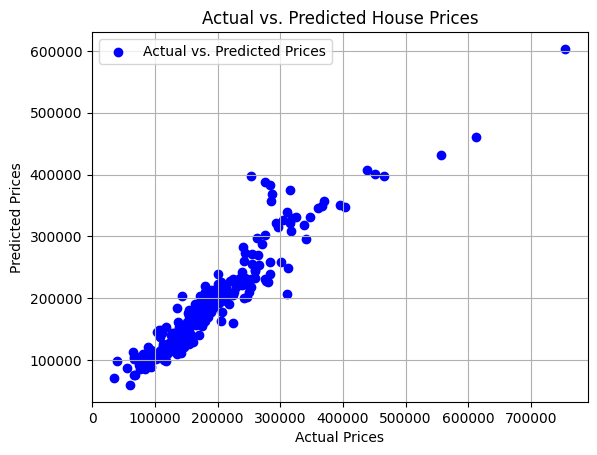

['trained_model.joblib']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import joblib
# Load the training data
train_data = pd.read_csv('train.csv')

# Drop columns with many missing values
cols_to_drop = ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', '3SsnPorch']
train_data.drop(cols_to_drop, axis=1, inplace=True)

# Handle categorical columns
categorical_columns = [
    "MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig",
    "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
    "ExterQual", "ExterCond", "Foundation", "Heating", "HeatingQC",
    "CentralAir", "KitchenQual", "Functional", "PavedDrive", "SaleType",
    "SaleCondition"
]

train_data = pd.get_dummies(train_data, columns=categorical_columns)

# Feature Engineering
train_data["TotalSF"] = train_data["1stFlrSF"] + train_data["2ndFlrSF"] + train_data["TotalBsmtSF"]

# Select columns for modeling
features = train_data.columns.difference(["SalePrice"])
X = train_data[features]
y = train_data["SalePrice"]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=75, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Display a table of actual vs. predicted prices
results_df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred})
print(results_df)

# Scatter plot for actual vs. predicted prices
plt.scatter(y_test, y_pred, c='b', label='Actual vs. Predicted Prices')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()





# Train the model
model = RandomForestRegressor(n_estimators=75, random_state=42)
model.fit(X_train, y_train)

# Save the trained model
joblib.dump(model, 'trained_model.joblib')


Out of the columns I tried Dropping below, only 3SsnPorch increased the Correlation when dropped.

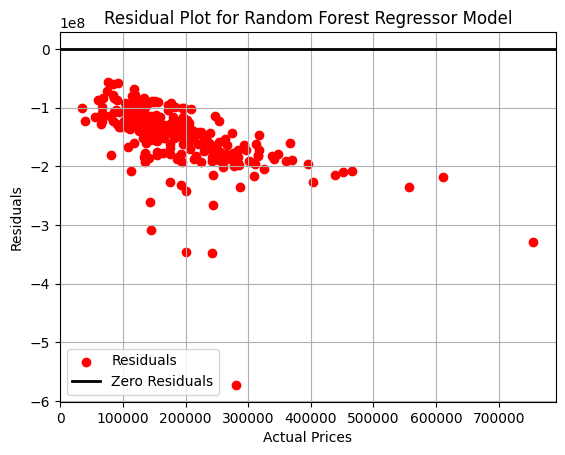

In [ ]:
import numpy as np

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Residual plot
plt.scatter(y_test, residuals, c='r', label='Residuals')
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, label='Zero Residuals')
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot for Random Forest Regressor Model")
plt.legend()
plt.grid(True)
plt.show()


Fun Parameter: This is the closest prediction for the RFR model!

In [ ]:
# Calculate residuals
residuals = y_test - y_pred.flatten()

# Find indices of data points with the lowest absolute residual
indices_of_lowest_residuals = (abs(residuals) == abs(residuals).min())

# Get the corresponding actual and predicted prices for all data points with the lowest residuals
lowest_residuals = residuals[indices_of_lowest_residuals]
actual_prices = y_test[indices_of_lowest_residuals]
predicted_prices = y_pred.flatten()[indices_of_lowest_residuals]

# Print the information for all data points with the lowest residuals
for i, (actual_price, predicted_price, residual) in enumerate(zip(actual_prices, predicted_prices, lowest_residuals)):
    print(f"Data Point {i + 1}")
    print(f"Actual Price: {actual_price}")
    print(f"Predicted Price: {predicted_price}")
    print(f"Residual: {residual}")
    print()


Data Point 1
Actual Price: 115000
Predicted Price: 115078.56
Residual: -78.55999999999767



$78 Dollars less is the closest prediction.

Adding Interest Rates into the mix as a prediction factor.

In [ ]:
years_sold = train_data["YrSold"].unique()

# Sort the unique years in ascending order
unique_years_sold = sorted(years_sold)

# Print each unique year when houses were sold
print("Unique Years When the Houses Were Sold:")
for year in unique_years_sold:
    print(year)


Unique Years When the Houses Were Sold:
2006
2007
2008
2009
2010


In [ ]:
#import pandas as pd
#pd.set_option('display.max_rows', None)
#Interest_rates = pd.read_csv('DOC_13699.csv')

#print(Interest_rates)


#4.1875 2010
#4.125 2009
#4.5625 2008
#4.875 2007
#5.125 2006

interest_rate = []
for index, row in train_data.iterrows():
  if row['YrSold'] == 2008:
    interest_rate.append(4.5625)
  elif row['YrSold'] == 2009:
    interest_rate.append(4.125)
  elif row['YrSold'] == 2010:
    interest_rate.append(4.1875)
  elif row['YrSold'] == 2007:
    interest_rate.append(4.875)
  elif row['YrSold'] == 2006:
    interest_rate.append(5.125)
train_data["InterestRate"] = interest_rate
print(train_data)



        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1          60         65.0     8450            7            5   
1        2          20         80.0     9600            6            8   
2        3          60         68.0    11250            7            5   
3        4          70         60.0     9550            7            5   
4        5          60         84.0    14260            8            5   
...    ...         ...          ...      ...          ...          ...   
1455  1456          60         62.0     7917            6            5   
1456  1457          20         85.0    13175            6            6   
1457  1458          70         66.0     9042            7            9   
1458  1459          20         68.0     9717            5            6   
1459  1460          20         75.0     9937            5            6   

      YearBuilt  YearRemodAdd  BsmtFinSF1  BsmtFinSF2  ...  SaleType_Oth  \
0          2003          2003      

Prediction Passing In Interest Rates

R-squared: 0.886055435802188
      Actual Prices  Predicted Prices
892          154500     140447.666667
1105         325000     332417.040000
413          115000     116245.333333
522          159000     159175.333333
1036         315500     321173.920000
...             ...               ...
479           89471     120123.666667
1361         260000     243802.480000
802          189000     177928.666667
651          108000     136163.333333
722          124500     118280.666667

[292 rows x 2 columns]


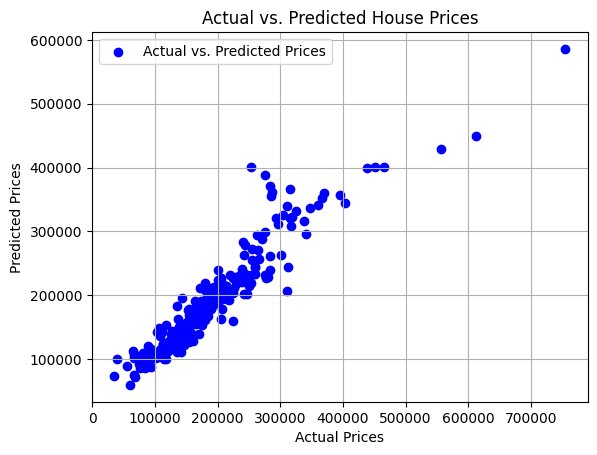

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Load the training data
train_data = pd.read_csv('train.csv')


interest_rate = []
for index, row in train_data.iterrows():
  if row['YrSold'] == 2008:
    interest_rate.append(4.5625)
  elif row['YrSold'] == 2009:
    interest_rate.append(4.125)
  elif row['YrSold'] == 2010:
    interest_rate.append(4.1875)
  elif row['YrSold'] == 2007:
    interest_rate.append(4.875)
  elif row['YrSold'] == 2006:
    interest_rate.append(5.125)
train_data["InterestRate"] = interest_rate





# Drop columns with many missing values
cols_to_drop = ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', '3SsnPorch']
train_data.drop(cols_to_drop, axis=1, inplace=True)

# Handle categorical columns
categorical_columns = [
    "MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig",
    "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
    "ExterQual", "ExterCond", "Foundation", "Heating", "HeatingQC",
    "CentralAir", "KitchenQual", "Functional", "PavedDrive", "SaleType",
    "SaleCondition"
]

train_data = pd.get_dummies(train_data, columns=categorical_columns)

# Feature Engineering
train_data["TotalSF"] = train_data["1stFlrSF"] + train_data["2ndFlrSF"] + train_data["TotalBsmtSF"]

# Select columns for modeling
features = train_data.columns.difference(["SalePrice"])
X = train_data[features]
y = train_data["SalePrice"]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)








# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=75, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Display a table of actual vs. predicted prices
results_df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred})
print(results_df)

# Scatter plot for actual vs. predicted prices
plt.scatter(y_test, y_pred, c='b', label='Actual vs. Predicted Prices')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()


PCA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the training data
train_data = pd.read_csv('train.csv')

interest_rate = []
for index, row in train_data.iterrows():
    if row['YrSold'] == 2008:
        interest_rate.append(4.5625)
    elif row['YrSold'] == 2009:
        interest_rate.append(4.125)
    elif row['YrSold'] == 2010:
        interest_rate.append(4.1875)
    elif row['YrSold'] == 2007:
        interest_rate.append(4.875)
    elif row['YrSold'] == 2006:
        interest_rate.append(5.125)
train_data["InterestRate"] = interest_rate

# Drop columns with many missing values
cols_to_drop = ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', '3SsnPorch']
train_data.drop(cols_to_drop, axis=1, inplace=True)

# Handle categorical columns
categorical_columns = [
    "MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig",
    "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
    "ExterQual", "ExterCond", "Foundation", "Heating", "HeatingQC",
    "CentralAir", "KitchenQual", "Functional", "PavedDrive", "SaleType",
    "SaleCondition"
]

train_data = pd.get_dummies(train_data, columns=categorical_columns)

# Feature Engineering
train_data["TotalSF"] = train_data["1stFlrSF"] + train_data["2ndFlrSF"] + train_data["TotalBsmtSF"]

# Select columns for modeling
features = train_data.columns.difference(["SalePrice"])
X = train_data[features]
y = train_data["SalePrice"]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model without PCA
model_without_pca = RandomForestRegressor(n_estimators=75, random_state=42)
model_without_pca.fit(X_train, y_train)
y_pred_without_pca = model_without_pca.predict(X_test)

# Evaluate the model without PCA
mse_without_pca = mean_squared_error(y_test, y_pred_without_pca)
r2_without_pca = r2_score(y_test, y_pred_without_pca)

print("Without PCA:")
print(f"MSE: {mse_without_pca}")
print(f"R-squared: {r2_without_pca}")

# Apply PCA on the entire dataset
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Split the PCA-transformed data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model with PCA
model_with_pca = RandomForestRegressor(n_estimators=75, random_state=42)
model_with_pca.fit(X_train_pca, y_train_pca)
y_pred_with_pca = model_with_pca.predict(X_test_pca)

# Evaluate the model with PCA
mse_with_pca = mean_squared_error(y_test_pca, y_pred_with_pca)
r2_with_pca = r2_score(y_test_pca, y_pred_with_pca)

print("\nWith PCA:")
print(f"MSE: {mse_with_pca}")
print(f"R-squared: {r2_with_pca}")


Without PCA:
MSE: 873991976.9329929
R-squared: 0.886055435802188

With PCA:
MSE: 1891405153.4602854
R-squared: 0.7534126838454365


Tested for overfitting by trying a different dataset with the same processing model

R-squared: 0.8047536005405933
       Actual Prices  Predicted Prices
20046        0.47700          0.513590
3024         0.45800          0.756050
15663        5.00001          4.908727
20484        2.18600          2.509410
9814         2.78000          2.289350
...              ...               ...
15362        2.63300          2.291380
16623        2.66800          1.982260
18086        5.00001          4.782829
2144         0.72300          0.717330
3665         1.51500          1.635930

[4128 rows x 2 columns]


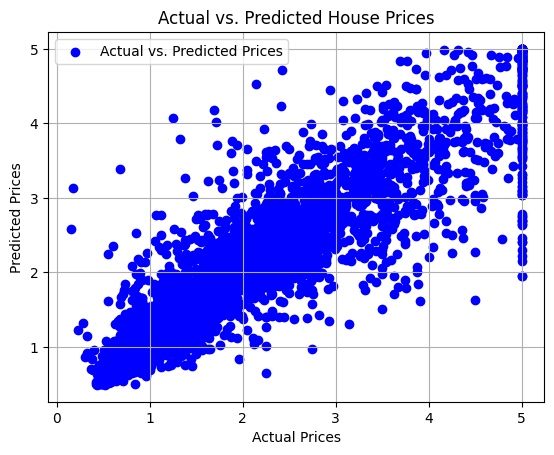

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.datasets import fetch_california_housing

# Load the California housing dataset
california_housing = fetch_california_housing()
data = pd.DataFrame(data=california_housing.data, columns=california_housing.feature_names)
data['target'] = california_housing.target

# Select columns for modeling
features = data.columns.difference(["target"])
X = data[features]
y = data["target"]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Display a table of actual vs. predicted prices
results_df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred})
print(results_df)

# Scatter plot for actual vs. predicted prices
plt.scatter(y_test, y_pred, c='b', label='Actual vs. Predicted Prices')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()


Method Testing:

2. Tensorflow Keras NN

Epoch 1/50
37/37 [==============================] - 1s 3ms/step - loss: 38884798464.0000
Epoch 2/50
37/37 [==============================] - 0s 2ms/step - loss: 38880423936.0000
Epoch 3/50
37/37 [==============================] - 0s 3ms/step - loss: 38865489920.0000
Epoch 4/50
37/37 [==============================] - 0s 2ms/step - loss: 38826594304.0000
Epoch 5/50
37/37 [==============================] - 0s 3ms/step - loss: 38744846336.0000
Epoch 6/50
37/37 [==============================] - 0s 2ms/step - loss: 38604636160.0000
Epoch 7/50
37/37 [==============================] - 0s 2ms/step - loss: 38387474432.0000
Epoch 8/50
37/37 [==============================] - 0s 3ms/step - loss: 38077542400.0000
Epoch 9/50
37/37 [==============================] - 0s 4ms/step - loss: 37667864576.0000
Epoch 10/50
37/37 [==============================] - 0s 4ms/step - loss: 37142982656.0000
Epoch 11/50
37/37 [==============================] - 0s 4ms/step - loss: 36492673024.0000
Epoch 12/50
37/37 [

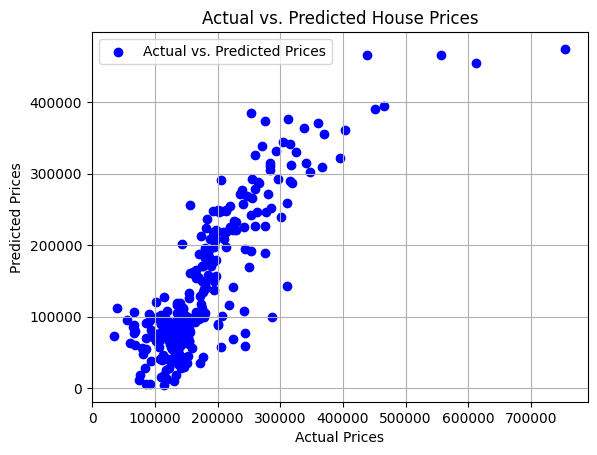

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Load the training data
train_data = pd.read_csv('train.csv')

# Drop columns with many missing values
cols_to_drop = ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', '3SsnPorch']
train_data.drop(cols_to_drop, axis=1, inplace=True)

# Handle categorical columns
categorical_columns = [
    "MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig",
    "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
    "ExterQual", "ExterCond", "Foundation", "Heating", "HeatingQC",
    "CentralAir", "KitchenQual", "Functional", "PavedDrive", "SaleType",
    "SaleCondition"
]

train_data = pd.get_dummies(train_data, columns=categorical_columns)

# Feature Engineering
train_data["TotalSF"] = train_data["1stFlrSF"] + train_data["2ndFlrSF"] + train_data["TotalBsmtSF"]

# Select columns for modeling
features = train_data.columns.difference(["SalePrice"])
features = features.difference(["1stFlrSF", "2ndFlrSF", "TotalBsmtSF"])  # Remove individual SF features
features = features.union(["TotalSF"])  # Include the new TotalSF feature

X = train_data[features]
y = train_data["SalePrice"]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build a Neural Network model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))  # Output layer with 1 neuron for regression

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, verbose=1)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled).flatten()

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"R-squared: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Display a table of actual vs. predicted prices
results_df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred})
print(results_df)

# Scatter plot for actual vs. predicted prices
plt.scatter(y_test, y_pred, c='b', label='Actual vs. Predicted Prices')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()


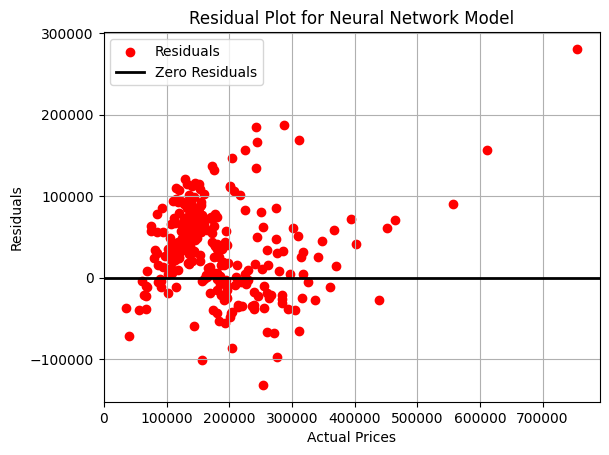

R-squared: 0.47128610286524186
Mean Absolute Error: 50726.969877060146
Mean Squared Error: 4055408061.296773
      Actual Prices  Predicted Prices      Residuals
892          154500      92630.757812   61869.242188
1105         325000     330794.250000   -5794.250000
413          115000      88214.781250   26785.218750
522          159000      56159.640625  102840.359375
1036         315500     340819.812500  -25319.812500
...             ...               ...            ...
479           89471      91374.593750   -1903.593750
1361         260000     326271.281250  -66271.281250
802          189000     153888.859375   35111.140625
651          108000     100385.007812    7614.992188
722          124500      81687.335938   42812.664062

[292 rows x 3 columns]


In [ ]:
import numpy as np

# Calculate residuals
residuals = y_test - y_pred

# Residual plot
plt.scatter(y_test, residuals, c='r', label='Residuals')
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, label='Zero Residuals')
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot for Neural Network Model")
plt.legend()
plt.grid(True)
plt.show()

# Additional evaluation metrics
print(f"R-squared: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")

# Display a table of actual vs. predicted prices and residuals
results_df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred, 'Residuals': residuals})
print(results_df)


3. Gradient Boosting Regression (GBR)

R-squared: 0.8952208433968206
      Actual Prices  Predicted Prices
892          154500     140091.757853
1105         325000     335432.629912
413          115000     114066.617633
522          159000     151881.173387
1036         315500     316184.422862
...             ...               ...
479           89471     116463.262423
1361         260000     248017.954010
802          189000     177240.626820
651          108000     120472.722406
722          124500     117347.392653

[292 rows x 2 columns]


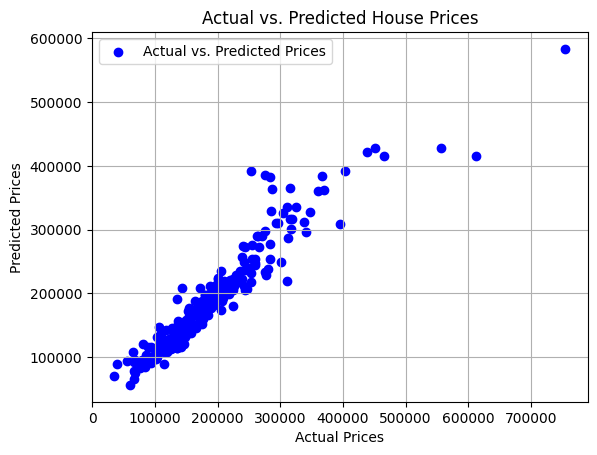

['trained_model.joblib']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import joblib

# Load the training data
train_data = pd.read_csv('train.csv')

# Drop columns with many missing values
cols_to_drop = ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', '3SsnPorch']
train_data.drop(cols_to_drop, axis=1, inplace=True)

# Handle categorical columns
categorical_columns = [
    "MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig",
    "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
    "ExterQual", "ExterCond", "Foundation", "Heating", "HeatingQC",
    "CentralAir", "KitchenQual", "Functional", "PavedDrive", "SaleType",
    "SaleCondition"
]

train_data = pd.get_dummies(train_data, columns=categorical_columns)

# Feature Engineering
train_data["TotalSF"] = train_data["1stFlrSF"] + train_data["2ndFlrSF"] + train_data["TotalBsmtSF"]

# Select columns for modeling
features = train_data.columns.difference(["SalePrice"])
X = train_data[features]
y = train_data["SalePrice"]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Gradient Boosting Regressor model
model = GradientBoostingRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Display a table of actual vs. predicted prices
results_df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred})
print(results_df)

# Scatter plot for actual vs. predicted prices
plt.scatter(y_test, y_pred, c='b', label='Actual vs. Predicted Prices')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()

# Save the trained model
joblib.dump(model, 'trained_model.joblib')


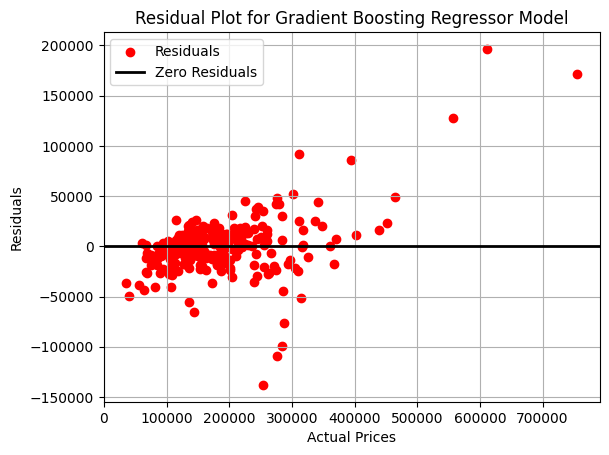

R-squared: 0.8952208433968206
      Actual Prices  Predicted Prices     Residuals
892          154500     140091.757853  14408.242147
1105         325000     335432.629912 -10432.629912
413          115000     114066.617633    933.382367
522          159000     151881.173387   7118.826613
1036         315500     316184.422862   -684.422862
...             ...               ...           ...
479           89471     116463.262423 -26992.262423
1361         260000     248017.954010  11982.045990
802          189000     177240.626820  11759.373180
651          108000     120472.722406 -12472.722406
722          124500     117347.392653   7152.607347

[292 rows x 3 columns]


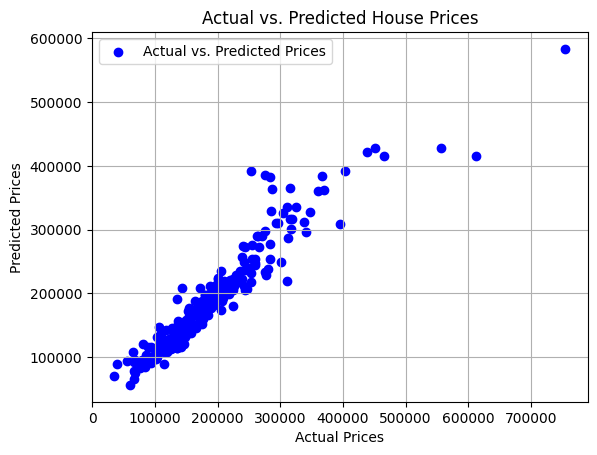

['trained_model_gbregressor.joblib']

In [ ]:
import numpy as np

# Make predictions on the test data
y_pred = model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

# Residual plot
plt.scatter(y_test, residuals, c='r', label='Residuals')
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, label='Zero Residuals')
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot for Gradient Boosting Regressor Model")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Display a table of actual vs. predicted prices and residuals
results_df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred, 'Residuals': residuals})
print(results_df)

# Scatter plot for actual vs. predicted prices
plt.scatter(y_test, y_pred, c='b', label='Actual vs. Predicted Prices')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()

# Save the trained model
joblib.dump(model, 'trained_model_gbregressor.joblib')


4. Support Vector Regression (SVR)

Testing Different C values for SVR

R-squared for C=0.001: -0.02475022404032612
R-squared for C=0.01: -0.02275932260776181
R-squared for C=0.1: -0.003262796724585071
R-squared for C=1: 0.16894962471187847
R-squared for C=10: 0.6961243897876079
R-squared for C=100: 0.8570223433686821
R-squared for C=1000: 0.881772664915947

Best C value: 1000
R-squared for the best C value: 0.881772664915947


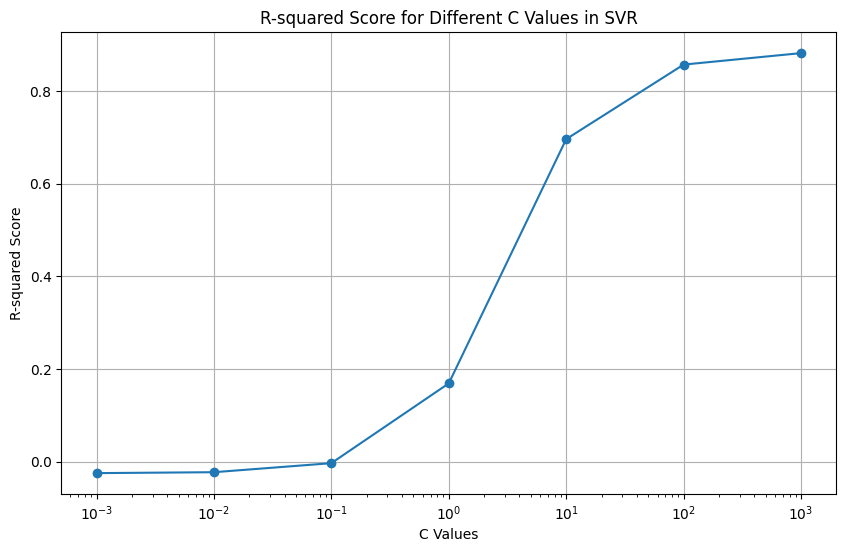

['best_trained_model_svr.joblib']

In [ ]:
import numpy as np

# Different values of C to test
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Results dictionary to store R-squared scores for each C value
results = {}

# Iterate over different C values
for C in C_values:
    # Create a Support Vector Regressor model with the current C value
    model = SVR(kernel='linear', C=C)

    # Train the model on the training data
    model.fit(X_train_scaled, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test_scaled)

    # Evaluate the model and store the R-squared score for the current C value
    r2 = r2_score(y_test, y_pred)
    results[C] = r2

    # Display R-squared score for the current C value
    print(f"R-squared for C={C}: {r2}")

# Find the best C value based on the highest R-squared score
best_C = max(results, key=results.get)
best_r2 = results[best_C]

# Display the best C value and corresponding R-squared score
print(f"\nBest C value: {best_C}")
print(f"R-squared for the best C value: {best_r2}")

# Plot R-squared scores for different C values
plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='-')
plt.xscale('log')  # Use a logarithmic scale for better visualization
plt.xlabel('C Values')
plt.ylabel('R-squared Score')
plt.title('R-squared Score for Different C Values in SVR')
plt.grid(True)
plt.show()

# Create a Support Vector Regressor model with the best C value
best_model = SVR(kernel='linear', C=best_C)

# Train the best model on the entire training data
best_model.fit(X_train_scaled, y_train)

# Save the best trained model
joblib.dump(best_model, 'best_trained_model_svr.joblib')


Although 1000 was technically the most competent, it has diminishing results as we increase past 100. In this case, I will use 1000, but it might be better to use 100 for larger or more complex datsets and problems.

R-squared: 0.8816736803796039
      Actual Prices  Predicted Prices
892          154500     152587.760309
1105         325000     316035.544948
413          115000      96991.051992
522          159000     174054.141586
1036         315500     300587.472811
...             ...               ...
479           89471     152239.151622
1361         260000     256756.398931
802          189000     186161.973987
651          108000      96642.095809
722          124500     112516.735820

[292 rows x 2 columns]


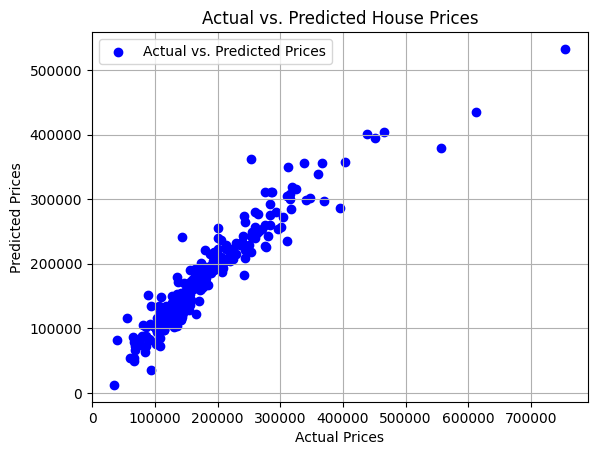

['trained_model_svr.joblib']

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import joblib

# Load the training data
train_data = pd.read_csv('train.csv')

# Drop columns with many missing values
cols_to_drop = ['Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond',
                'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical',
                'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish',
                'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', '3SsnPorch']
train_data.drop(cols_to_drop, axis=1, inplace=True)

# Handle categorical columns
categorical_columns = [
    "MSZoning", "Street", "LotShape", "LandContour", "Utilities", "LotConfig",
    "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
    "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
    "ExterQual", "ExterCond", "Foundation", "Heating", "HeatingQC",
    "CentralAir", "KitchenQual", "Functional", "PavedDrive", "SaleType",
    "SaleCondition"
]

train_data = pd.get_dummies(train_data, columns=categorical_columns)

# Feature Engineering
train_data["TotalSF"] = train_data["1stFlrSF"] + train_data["2ndFlrSF"] + train_data["TotalBsmtSF"]

# Select columns for modeling
features = train_data.columns.difference(["SalePrice"])
X = train_data[features]
y = train_data["SalePrice"]

# Handle missing values using SimpleImputer
imputer = SimpleImputer(strategy='median')
X = np.array(imputer.fit_transform(X))  # Convert to NumPy array

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features using StandardScaler for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a Support Vector Regressor model
model = SVR(kernel='linear', C=1000)

# Train the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# Display a table of actual vs. predicted prices
results_df = pd.DataFrame({'Actual Prices': y_test, 'Predicted Prices': y_pred})
print(results_df)

# Scatter plot for actual vs. predicted prices
plt.scatter(y_test, y_pred, c='b', label='Actual vs. Predicted Prices')
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted House Prices")
plt.legend()
plt.grid(True)
plt.show()

# Save the trained model
joblib.dump(model, 'trained_model_svr.joblib')


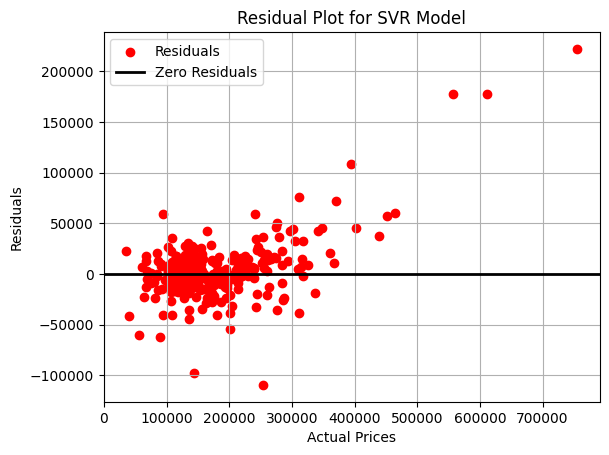

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Residual plot
plt.scatter(y_test, residuals, c='r', label='Residuals')
plt.axhline(y=0, color='k', linestyle='-', linewidth=2, label='Zero Residuals')
plt.xlabel("Actual Prices")
plt.ylabel("Residuals")
plt.title("Residual Plot for SVR Model")
plt.legend()
plt.grid(True)
plt.show()
